In [1]:
# !pip install gcsfs

from glob import glob
import math, os, time, re, json, shutil, pprint, random
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Input, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import add as add_concat
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from IPython.display import clear_output
import IPython.display as display

import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

Tensorflow version 2.1.0


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
TEST_DS_PATH = KaggleDatasets().get_gcs_path('testtfrecords')
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tfrecords-bengali-grapheme')
# !gsutil ls $GCS_DS_PATH

In [4]:
if strategy.num_replicas_in_sync == 1: # single GPU or CPU
    BATCH_SIZE = 256
    VALIDATION_BATCH_SIZE = 256
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    
FILENAMES = tf.io.gfile.glob(GCS_DS_PATH+'/*.tfrec')
TEST_FILENAMES  = tf.io.gfile.glob(TEST_DS_PATH+'/*.tfrec')

IMAGE_SIZE = [64, 64]
if K.image_data_format() == 'channels_first':
    SHAPE = (3,*IMAGE_SIZE)
else:
    SHAPE = (*IMAGE_SIZE, 3)
SIZE_TFRECORD = 128
split = int(len(FILENAMES)*0.81)
TRAINING_FILENAMES = FILENAMES[:split]
VALIDATION_FILENAMES = FILENAMES[split:]
STEP_PER_EPOCH = (len(TRAINING_FILENAMES)*SIZE_TFRECORD)//BATCH_SIZE
VALIDATION_STEP_PER_EPOCH = (len(VALIDATION_FILENAMES)*SIZE_TFRECORD)//VALIDATION_BATCH_SIZE
print(len(TRAINING_FILENAMES))
print(len(VALIDATION_FILENAMES))

1271
299


In [5]:
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    subplot += 1
    if i==2:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = IMAGE_SIZE[1]
    th = IMAGE_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                   )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def normalize(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label


def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     image = tf.image.rot90(image, k=random.randrange(4))
#     image = tf.image.random_saturation(image, 0.6, 1.6)
#     image = tf.image.random_hue(image, 0.08)
#     image = tf.image.random_contrast(image, 0.7, 1.3)
#     image = tf.image.random_brightness(image, 0.05)
    return image, label

def count_data_items(filenames):
    return np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames])

def force_image_sizes(dataset):
    reshape_images = lambda image, label: (tf.reshape(image, SHAPE), label)   
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

In [6]:
def read_tfrecord(example):
    features = {
      "image": tf.io.FixedLenFeature([], tf.string), 
      "grapheme_root": tf.io.FixedLenFeature([], tf.int64),       
      "vowel_diacritic": tf.io.FixedLenFeature([], tf.int64),       
      "consonant_diacritic": tf.io.FixedLenFeature([], tf.int64),  

      "label":         tf.io.FixedLenFeature([], tf.string),         
      "size":          tf.io.FixedLenFeature([2], tf.int64),     
      "head_root_hot": tf.io.VarLenFeature(tf.float32),
      "head_vowel_hot": tf.io.VarLenFeature(tf.float32),
      "head_consonant_hot": tf.io.VarLenFeature(tf.float32),
    }

    example = tf.io.parse_single_example(example, features)

    image = tf.image.decode_image(example['image'], channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.0 
    
    grapheme_root = example['grapheme_root']
    vowel_diacritic = example['vowel_diacritic']
    consonant_diacritic = example['consonant_diacritic']
     
    head_root_hot = tf.sparse.to_dense(example['head_root_hot'])
    head_vowel_hot = tf.sparse.to_dense(example['head_vowel_hot'])
    head_consonant_hot = tf.sparse.to_dense(example['head_consonant_hot'])
    
    head_root_hot = tf.reshape(head_root_hot, [168])
    head_vowel_hot = tf.reshape(head_vowel_hot, [11])
    head_consonant_hot = tf.reshape(head_consonant_hot, [7])
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    return image,  {"head_root": head_root_hot, "head_vowel": head_vowel_hot, "head_consonant": head_consonant_hot}

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
#     dataset = dataset.map(resize_and_crop_image, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset)
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
#     dataset = dataset.map(augmentation, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(10042)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [7]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def plot_learning_rate(lr_func, epochs):
    xx = np.arange(epochs+1, dtype=np.float)
    y = [lr_decay(x) for x in xx]
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xlabel('epochs')
    ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
    ax.minorticks_on()
    ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    ax.step(xx,y, linewidth=3, where='post')
    display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
    def __init__(self, sample_rate=1, zoom=1):
        self.sample_rate = sample_rate
        self.step = 0
        self.zoom = zoom
        self.steps_per_epoch = STEP_PER_EPOCH

    def on_train_begin(self, logs={}):
        self.batch_history = {}
        self.batch_step = []
        self.epoch_history = {}
        self.epoch_step = []
        self.fig, self.axes = plt.subplots(3, 2, figsize=(19, 19))
        self.fig.subplots_adjust(wspace=0.3, hspace=0.25)
        plt.ioff()
      
        
    def on_batch_end(self, batch, logs={}):
        if (batch % self.sample_rate) == 0:
            self.batch_step.append(self.step)
            for k,v in logs.items():
              # do not log "batch" and "size" metrics that do not change
              # do not log training accuracy "acc"
                if k=='batch' or k=='size' or k == 'loss':# or k=='acc':
                    continue
                self.batch_history.setdefault(k, []).append(v)
        self.step += 1

    def on_epoch_end(self, epoch, logs={}):
        plt.close(self.fig)
        for axes in self.axes:
            axes[0].cla()
            axes[1].cla()

            axes[0].set_ylim(0, 1.2/self.zoom)
            axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
        self.epoch_step.append(self.step)
        for k,v in logs.items():
          # only log validation metrics
            if not k.startswith('val_') or k == 'val_loss':
                continue
            self.epoch_history.setdefault(k, []).append(v)

        display.clear_output(wait=True)
        
        for count, (k,v) in enumerate(self.batch_history.items()):
            if count <= 2:
                self.axes[count][0].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[len(v)-1]))
            else:
                self.axes[count-3][1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[len(v)-1]))
      
        for count, (k,v) in enumerate(self.epoch_history.items()):
            if count <= 2:
                self.axes[count][0].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[epoch]), linewidth=3)
            else:
                self.axes[count-3][1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label='{}: {:.3f}'.format(k, v[epoch]), linewidth=3)
        for axes in self.axes:
            axes[0].legend()
            axes[1].legend()
            axes[0].set_xlabel('epochs')
            axes[1].set_xlabel('epochs')
            axes[0].minorticks_on()
            axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
            axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
            axes[1].minorticks_on()
            axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
            axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        display.display(self.fig)

In [8]:
# len(list(dataset.as_numpy_iterator()))
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

In [9]:
def weighted_cross_entropy(beta):
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=beta)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

  return loss

def balanced_cross_entropy(beta):
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss * (1 - beta))

  return loss

def focal_loss(alpha=0.25, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

  return loss

In [10]:
with strategy.scope():
    bnmomemtum=0.8
    def fire(x, filters, kernel_size):
        if not isinstance(filters, list): 
            filters = [filters, filters]  
        x = SeparableConv2D(filters[0], kernel_size, padding='same', use_bias=False)(x)
        x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(filters[1], kernel_size, padding='same', use_bias=False)(x)
        return BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
    
    def fire_module_separable_conv(filters, kernel_size=(3, 3)):
        return lambda x: fire(x, filters, kernel_size)
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    img_input = Input(shape=SHAPE)

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
    x = Activation('relu')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(residual)

    x = fire_module_separable_conv(128)(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = add_concat([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(residual)

    x = Activation('relu')(x)
    x = fire_module_separable_conv(256)(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = add_concat([x, residual])

    for i in range(4):
        residual = x

        x = Activation('relu')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization(axis=channel_axis, center=True, scale=False, momentum=bnmomemtum)(x)
        x = Activation('relu')(x)
        x = fire_module_separable_conv(256)(x)
        
        x = add_concat([x, residual])


    x = fire_module_separable_conv([728, 1024])(x)
    x = Activation('relu')(x)
    y = GlobalAveragePooling2D()(x)
    
    y = Dense(1536)(y)
    y = Activation('relu')(y)
    y = Dropout(0.33)(y)
    
    y = Dense(512)(y)
    y = Activation('relu')(y)
    y = Dropout(0.33)(y)
    
    head_root = Dense(168, activation = 'softmax', name='head_root')(y)
    head_vowel = Dense(11, activation = 'softmax', name='head_vowel')(y)
    head_consonant = Dense(7, activation = 'softmax', name='head_consonant')(y)
   
    model = Model(inputs=img_input, outputs=[head_root, head_vowel, head_consonant]) 
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 31, 31, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 31, 31, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

0.001 0.0003269762440022512


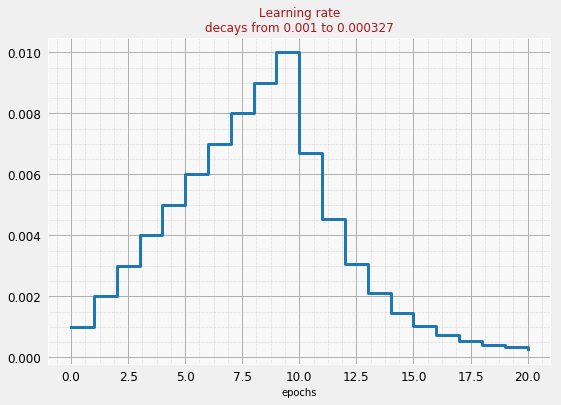

In [11]:
if strategy.num_replicas_in_sync == 1: # single GPU
    start_lr =  0.001
    min_lr = 0.000158
    max_lr = 0.01 * strategy.num_replicas_in_sync
    rampup_epochs = 9
    sustain_epochs = 0
    exp_decay = .666
else: # TPU pod
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

EPOCHS=20

def lr_decay(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_decay(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lr_decay(x) for x in rng]
plt.plot(rng, [lr_decay(x) for x in rng])
print(y[0], y[-1])
plot_learning_rate(lr_decay_callback, EPOCHS)

In [12]:
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_head_root_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True) 

plot_training = PlotTraining(sample_rate=10, zoom=1)
callbacks_list = [checkpoint, plot_training, lr_decay_callback]  #, 

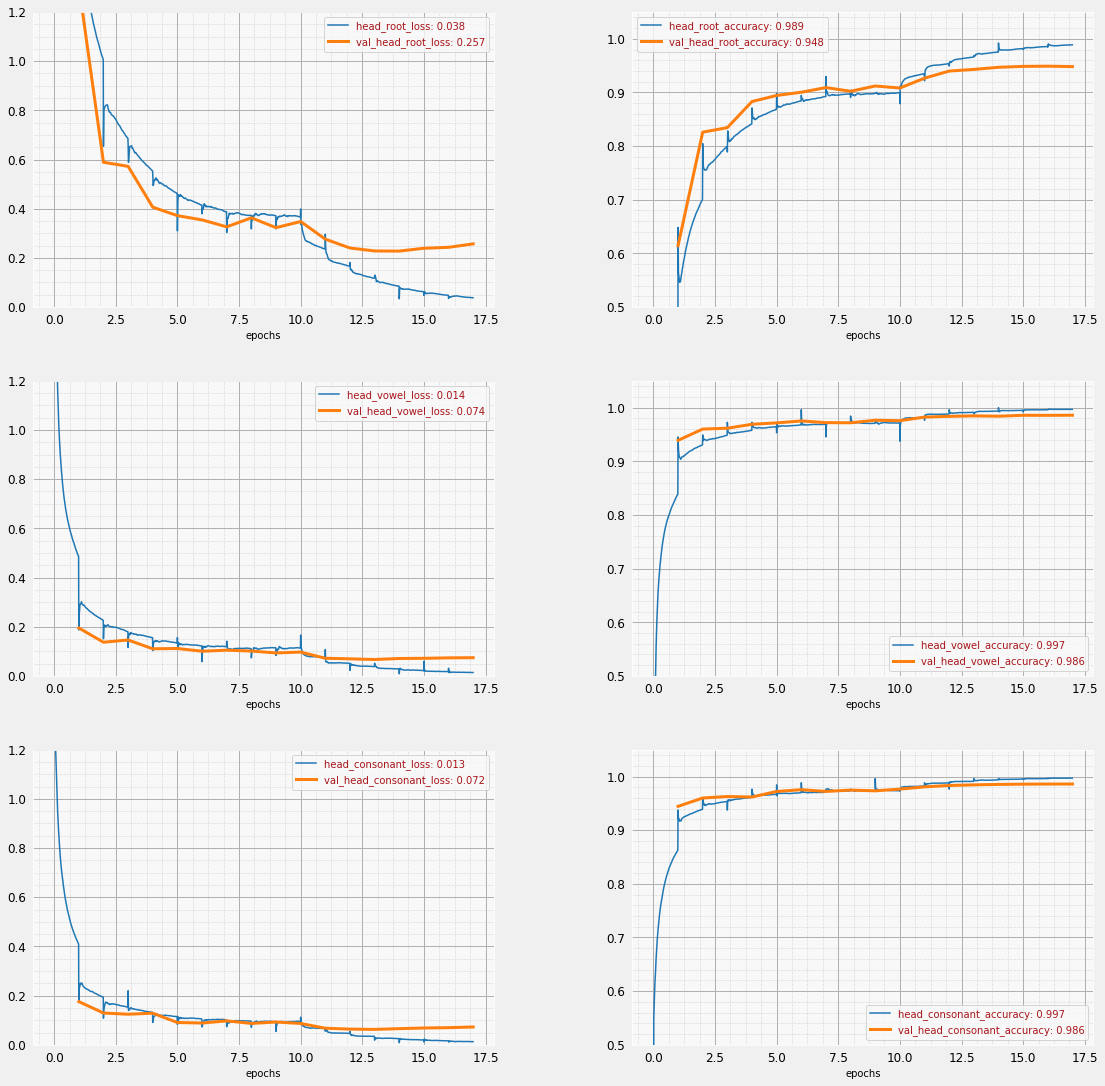

635/635 [==============================] - 183s 287ms/step - loss: 0.0645 - head_root_loss: 0.0378 - head_vowel_loss: 0.0139 - head_consonant_loss: 0.0128 - head_root_accuracy: 0.9888 - head_vowel_accuracy: 0.9969 - head_consonant_accuracy: 0.9971 - val_loss: 0.4036 - val_head_root_loss: 0.2570 - val_head_vowel_loss: 0.0742 - val_head_consonant_loss: 0.0724 - val_head_root_accuracy: 0.9482 - val_head_vowel_accuracy: 0.9859 - val_head_consonant_accuracy: 0.9860

Epoch 00018: LearningRateScheduler reducing learning rate to 0.0005389580842154117.
Epoch 18/20
216/635 [=========>....................] - ETA: 53s - loss: 0.0593 - head_root_loss: 0.0341 - head_vowel_loss: 0.0130 - head_consonant_loss: 0.0121 - head_root_accuracy: 0.9897 - head_vowel_accuracy: 0.9971 - head_consonant_accuracy: 0.9971

In [13]:
history = model.fit_generator(
    training_dataset, 
    steps_per_epoch=STEP_PER_EPOCH, 
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEP_PER_EPOCH,
    callbacks=callbacks_list)

In [14]:
model.load_weights(weight_path)
model.save('model_tpu_gpu_cpu.h5')

In [15]:
# if strategy.num_replicas_in_sync == 1: # single GPU or CPU
#     start_lr = 0.001
#     min_lr = 0.00001
#     max_lr = 0.03
#     rampup_epochs = 9
#     sustain_epochs = 0
#     exp_decay = .75
# else: # TPU pod
#     start_lr =  0.001
#     min_lr = 0.0158
#     max_lr = 0.01 * strategy.num_replicas_in_sync
#     rampup_epochs = 9
#     sustain_epochs = 0
#     exp_decay = .666

# EPOCHS = 20 # 30

In [16]:
def read_test_tfrecord(example):
    TEST_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "label": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, TEST_TFREC_FORMAT)
    image = tf.image.decode_image(example['image'], channels=3)
    image_model = tf.cast(image, tf.float32)/255.0 
    image_model = tf.reshape(image_model, SHAPE)
    head_root_hot_classes =  [x for x in range(168)]
    head_vowel_hot_classes =  [x  for x in range(11)]
    head_consonant_hot_classes = [x  for x in range(7)]
    label = example['label']
    return image_model, label

def load_test_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_test_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_test_dataset(filenames):
    dataset = load_test_dataset(filenames)
    return dataset


In [17]:
test = get_test_dataset(TEST_FILENAMES)
test = test.batch(1)

In [18]:
predicts = []
for i , (image, label) in enumerate(test):
    predict =  model.predict(image)
    preds = []
    for pred in predict:
        preds += [np.argmax(pred, axis=1).tolist()[0]]
    predicts += [[preds, label[0].numpy().decode("utf-8")]]
predicts

[[[3, 0, 0], 'Test_0.png'],
 [[148, 1, 4], 'Test_10.png'],
 [[93, 2, 0], 'Test_1.png'],
 [[21, 2, 0], 'Test_11.png'],
 [[19, 0, 0], 'Test_2.png'],
 [[119, 9, 0], 'Test_8.png'],
 [[115, 0, 0], 'Test_3.png'],
 [[137, 7, 0], 'Test_7.png'],
 [[55, 4, 0], 'Test_4.png'],
 [[133, 10, 0], 'Test_9.png'],
 [[115, 2, 0], 'Test_5.png'],
 [[147, 9, 5], 'Test_6.png']]

In [19]:
import pandas as pd
row_ids = []
target = []
for pred in predicts:
    row_id = pred[1].split('.')[0]
    consonant = row_id+'_consonant_diacritic'
    root = row_id+'_grapheme_root'
    vowel = row_id+'_vowel_diacritic'
    row_ids.append(consonant)
    target.append(pred[0][2])
    row_ids.append(root)
    target.append(pred[0][0])
    row_ids.append(vowel)
    target.append(pred[0][1])        

df_sample = pd.DataFrame({
    'row_id': row_ids,
    'target':target
},columns=['row_id','target'])

df_sample.to_csv('submission.csv',index=False)
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_10_consonant_diacritic,4
4,Test_10_grapheme_root,148
5,Test_10_vowel_diacritic,1
6,Test_1_consonant_diacritic,0
7,Test_1_grapheme_root,93
8,Test_1_vowel_diacritic,2
9,Test_11_consonant_diacritic,0
